In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
from IPython.core.pylabtools import figsize

In [2]:
class Kid(object):
    """
    Simulates behavior of kids that get bullied and get their lunch money taken away.
    """
    
    def __init__(self, kid_id, no_money_duration=5, conseuctive_bully_count_max=3):
        """
        If kid gets bullied 'conseuctive_bully_count_max' times in a row, he doesn't bring 
        lunch money for the next 'no_money_duration' days. If he gets bullied during this period, 
        the period resets.
        """
        self.kid_id = kid_id
        self.lunch_money_prob = np.random.rand()
        # Change below to np.inf to make sure UCB1 is working
        self.conseuctive_bully_count_max = conseuctive_bully_count_max 
        self.no_money_duration = no_money_duration
        self.reset()
    
    def reset(self):
        self.consecutive_bully_count = 0
        self.no_money_flag = False
        
    def bully(self):
        """Kid gets bullied and might potentially give up lunch money"""
        self.consecutive_bully_count += 1
        
        if self.consecutive_bully_count < self.conseuctive_bully_count_max:
            if self.consecutive_bully_count == (self.conseuctive_bully_count_max - 1):
                # If kid has lunch money today he'll fork it over but he begins no lunch money hiatus
                self.no_money_flag = True
                self.no_money_days = 0
                
            if np.random.rand() > self.lunch_money_prob:
                return (0.0)
            else:
                return (1.0)
        else:
            self.no_money_flag = True
            self.no_money_days = 0
            return (0.)
        
    def ignore(self):
        """Kid gets ignored, no lunch money taken"""
        if self.no_money_flag:
            self.no_money_days += 1            
            if self.no_money_days == self.no_money_duration:
                self.no_money_flag = False
                self.consecutive_bully_count = 0
        else:
            self.consecutive_bully_count = 0

In [3]:
# Make sure the Kid class is working
k = Kid(0)
k.lunch_money_prob = 1.0

for i in xrange(5):
    print k.bully()

print "... ignore for 5 days"

for i in xrange(5):
    k.ignore()
    
for i in xrange(5):
    print k.bully()    

1.0
1.0
0.0
0.0
0.0
... ignore for 5 days
1.0
1.0
0.0
0.0
0.0


In [4]:
class Exp3(object):
    
    def __init__(self, kids, gamma=0.10):
        self.kids = kids
        self.n_kids = len(kids)
        self.gamma = gamma
        self.weights = [1.0]*self.n_kids
        
    def update(self, kid_id):
        for kid in self.kids:
            if kid.kid_id == kid_id:
                reward = kid.bully()
                reward_hat = reward/self.probs[kid_id]
                
                # Update weight
                self.weights[kid_id] *= np.exp(self.gamma*reward_hat/self.n_kids)
            else:
                kid.ignore()
                
        return (reward)
                
    def select_kid(self):
        self.probs = [self.gamma/self.n_kids]*self.n_kids
        total_weight = np.sum(self.weights)
        for kid_id in xrange(self.n_kids):
            self.probs[kid_id] += (1.0 - self.gamma)*self.weights[kid_id]/total_weight
        
        return(np.random.choice(self.n_kids, p=self.probs))

In [5]:
class UCB1(object):
    
    def __init__(self, kids):
        self.kids = kids
        self.n_kids = len(kids)
        # Number of times each kid as been bullied
        self.counts = [0.0]*self.n_kids
        # Average reward for bullying each kid
        self.values = [0.0]*self.n_kids
    
    def update(self, kid_id):   
        self.counts[kid_id] += 1.0
        
        # Bully kid w/ kid_id
        for kid in self.kids:
            if kid.kid_id == kid_id:
                n = self.counts[kid_id]
                old_value = self.values[kid_id]
                reward = kid.bully()
                self.values[kid_id] = ((n - 1.)/n)*old_value + (1./n)*reward 
            else:
                kid.ignore()
        
        return (reward)
        
    def select_kid(self):
        # Make sure we sample each kid at least once
        for kid_id in xrange(self.n_kids):
            if self.counts[kid_id] == 0.0:
                return (kid_id)
        
        ucb_vals = [0.0]*self.n_kids
        total_counts = np.sum(self.counts)
        for kid_id in xrange(self.n_kids):
            boost = np.sqrt(2.0*np.log(total_counts)/self.counts[kid_id])
            ucb_vals[kid_id] = self.values[kid_id] + boost
            
        return (np.argmax(ucb_vals))            

In [6]:
class OmnipotentBully(object):
    
    def __init__(self, kids):
        self.kids = kids
        self.n_kids = len(kids)
    
    def update(self, kid_id):        
        # Bully kid w/ kid_id
        for kid in self.kids:
            if kid.kid_id == kid_id:
                reward = kid.bully()
            else:
                kid.ignore()
                
        return (reward)
        
    def select_kid(self):
        omni_vals = [0.0]*self.n_kids
        for kid in self.kids:
            if kid.no_money_flag:
                omni_vals[kid.kid_id] = 0.0
            else:
                omni_vals[kid.kid_id] = kid.lunch_money_prob
            
        return (np.argmax(omni_vals))

In [7]:
class RandomBully(object):
    
    def __init__(self, kids):
        self.kids = kids
        self.n_kids = len(kids)
    
    def update(self, kid_id):        
        # Bully kid w/ kid_id
        for kid in self.kids:
            if kid.kid_id == kid_id:
                reward = kid.bully()
            else:
                kid.ignore()
        
        return (reward)
        
    def select_kid(self):     
        kid = np.random.choice(self.kids)
            
        return (kid.kid_id)

## Initialize Analysis:

In [14]:
np.random.seed(3)
figsize(10, 8)
plt.xkcd()

n_kids = 10
horizon = 365*3
num_sims = 1500

kids = map(Kid, range(n_kids))
# kids = map(lambda x: Kid(x, conseuctive_bully_count_max=np.inf), range(n_kids))

for kid in kids:
    print "Kid Number: {0:2d}, P(lunch money) = {1:4.2f}".format(kid.kid_id, kid.lunch_money_prob)

Kid Number:  0, P(lunch money) = 0.55
Kid Number:  1, P(lunch money) = 0.71
Kid Number:  2, P(lunch money) = 0.29
Kid Number:  3, P(lunch money) = 0.51
Kid Number:  4, P(lunch money) = 0.89
Kid Number:  5, P(lunch money) = 0.90
Kid Number:  6, P(lunch money) = 0.13
Kid Number:  7, P(lunch money) = 0.21
Kid Number:  8, P(lunch money) = 0.05
Kid Number:  9, P(lunch money) = 0.44


In [17]:
def reset_kids(kids):
    for kid in kids:
        kid.reset()
    return 

def simulate_algorithm(horizon, num_sims, algorithm, kids, seed=1):
    
    np.random.seed(seed)
    reset_kids(kids)
    
    all_rewards = np.zeros([horizon, num_sims])
    for sim in xrange(num_sims):
        algo = algorithm(kids)
        rewards = []
        for t in xrange(horizon):
            chosen_kid_id = algo.select_kid()
            reward = algo.update(chosen_kid_id)
            rewards.append(reward)

        all_rewards[:, sim] = rewards
    
    cuml_rewards = all_rewards.cumsum(axis=0).mean(axis=1) 
    mean_rewards = all_rewards.mean(axis=1)
   
    return (mean_rewards, cuml_rewards)

## Simulations:

In [10]:
mean_rewards_random, cuml_rewards_random = simulate_algorithm(horizon, num_sims, RandomBully, kids)
mean_rewards_ucb1, cuml_rewards_ucb1 = simulate_algorithm(horizon, num_sims, UCB1, kids)
mean_rewards_omni, cuml_rewards_omni = simulate_algorithm(horizon, num_sims, OmnipotentBully, kids)
# mean_rewards_exp3, cuml_rewards_exp3 = simulate_algorithm(horizon, num_sims, Exp3, kids)

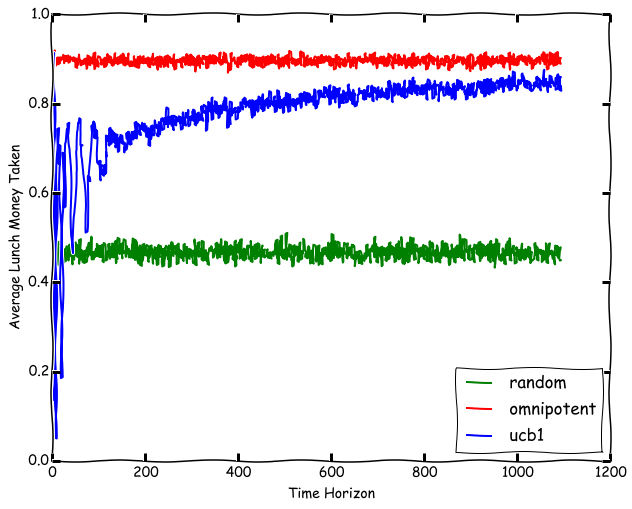

In [11]:
plt.plot(range(horizon), mean_rewards_random, '-g', label='random')
plt.plot(range(horizon), mean_rewards_omni, '-r', label='omnipotent')
plt.plot(range(horizon), mean_rewards_ucb1, '-b', label='ucb1')
# plt.plot(range(horizon), mean_rewards_exp3, '-y', label='exp3')

plt.legend(loc='best')
plt.xlabel('Time Horizon')
plt.ylabel('Average Lunch Money Taken');

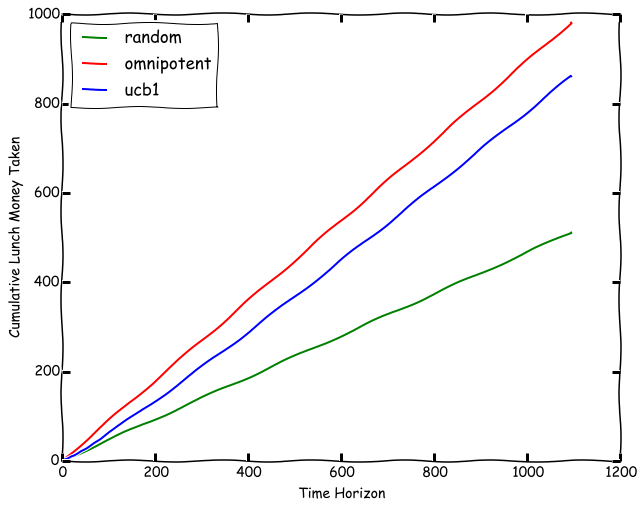

In [12]:
plt.plot(range(horizon), cuml_rewards_random, '-g', label='random')
plt.plot(range(horizon), cuml_rewards_omni, '-r', label='omnipotent')
plt.plot(range(horizon), cuml_rewards_ucb1, '-b', label='ucb1')
# plt.plot(range(horizon), cuml_rewards_exp3, '-y', label='exp3')

plt.legend(loc='best')
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Lunch Money Taken');

### Average reward for UCB1

In [21]:
np.random.seed(1)
reset_kids(kids)

avg_rewards = np.zeros([n_kids, horizon])
algo = UCB1(kids)
for t in xrange(horizon):
    chosen_kid_id = algo.select_kid()
    reward = algo.update(chosen_kid_id)
    avg_rewards[:, t] = algo.values

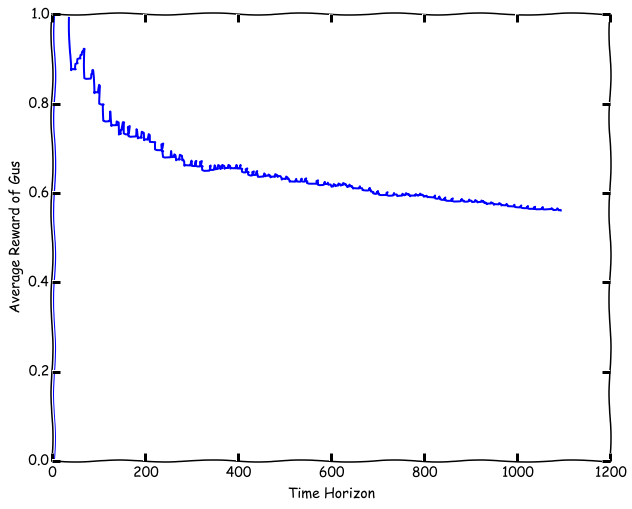

In [22]:
# Average reward over time for kid most likely to give up lnuch money
plt.plot(range(horizon), avg_rewards[5, :])
plt.xlabel('Time Horizon')
plt.ylabel('Average Reward of Gus');